#**Sentiment Analysis**

Sentiment analysis tries to capture subjective aspects in texts,
e.g., whether a tweet on Twitter shows a positive or negative mood of the author. Sentiment analysis is a text classification problem.
The difference to topic identification is that in sentiment analysis, we do not want to classify our documents by objective aspects (e.g., by
topics) but to get an idea of the subjective aspects in the text (e.g., positive or negative
feedback) [[1]](#scrollTo=P4arl7P3xUuB).

This notebook shows examples of sentiment analysis with ``simpletransformers`` [[2]](https://simpletransformers.ai/about/).


## **Sentiment analysis with ``simpletransformers``**

In this section, We show how to train and evaluate our own sentiment analysis model using the ``simpletransformers`` library and the Stanford’s large movie review dataset. 

This dataset contains 50,000 annotated movie reviews: 25,000 reviews in the training set
and another 25,000 reviews in the test set. Each review consists of text data including
HTML tags for line breaks and a label that can be either “positive” or “negative.” The
data is extracted from IMDb. IMDb uses a scoring system for the reviews. If the score is
less than or equal to 4 out of 10, a review is labeled “negative”; scores greater than or
equal to 7 are labeled “positive.” Reviews that receive between 4 and 7 points are considered neutral and not included in the dataset [[1]](#scrollTo=P4arl7P3xUuB).



We perform the following steps:
* Install the ``simpletransformers`` library
* Import other libraries and packages; ``pandas``, ``ClassificationModel``, ``train_test_split``and ``preprocessing``
* Download dataset from Kaggle
* Create a general classification model
* Fine-tune the general model
* Evaluate the fine-tuned model
* Make predictions for a given text

### Install ``simpletransformers``

First, we install the ``simpletransformers`` library. This library is based on the Hugging Face transformers library [[3]](https://huggingface.co/docs/transformers/index). ``simpletransformers`` helps us to quickly train and evaluate transformer models. For more details about the ``simpletransformers`` library, please refer to [[2]](https://simpletransformers.ai/about/).


In this notebook, we use the following functions of the ``simpletransformers``library:
* ``ClassificationModel()`` to create a general classification model
* ``train_model()`` to fine-tune the general model
* ``eval_model()`` to evaluate the fine-tuned model
* ``predict()`` to make predictions for a given text



**Note:**<br>
Deep Learning (DL) models typically run on CUDA-enabled GPUs as the performance is better compared to running on a CPU [[4]](https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda). CUDA is a parallel computing platform created by NVIDIA.

On all ``simpletransformers`` models, CUDA is enabled by default. Because of that, in order to proceed, we should enable CUDA in our GPU. If we use Google Colab, we do not need to do anything since CUDA is pre-installed. But we need to enable the GPU in our Colab top menu by clicking on "Runtime/Change runtime type" and choosing "GPU".
 
In order to proceed without CUDA, we run the following code snippets until we can disable CUDA in ["Create classification model"](#scrollTo=DmfjRTC21KCt).

In [1]:
# Install the simpletransformers library
# Important: If you see a button "RESTART RUNTIME" after installing simpletransformers, click on this button to restart the runtime.
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 12.6 MB/s 
     |████████████████████████████████| 1.2 MB 66.6 MB/s 
     |████████████████████████████████| 9.1 MB 34.8 MB/s 
     |████████████████████████████████| 362 kB 49.1 MB/s 
     |████████████████████████████████| 4.4 MB 50.9 MB/s 
     |████████████████████████████████| 1.8 MB 65.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 596 kB 20.1 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 181 kB 74.4 MB/s 
     |████████████████████████████████| 153 kB 71.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 63.4 MB/s 
     |████████████████████████████████| 140 kB 75.3 MB/s 
     |█████████████████████████████

### Import libraries and packages

### Import libraries and packages
We import all necessary libraries: In addition to ``simpletransformers``,
we need functions from ``sklearn`` and ``pandas`` to process our dataset. For more details about the ``sklearn`` and ``pandas`` libraries, please refer to [[5]](https://scikit-learn.org/stable/) and [[6]](https://pandas.pydata.org/).


In [ ]:
# Import the pandas library
import pandas as pd

# Import the "ClassificationModel" package for text classification tasks
from simpletransformers.classification import ClassificationModel

# Import the "train_test_split" function from the sklearn library
from sklearn.model_selection import train_test_split

# Import the "preprocessing" package from sklearn
from sklearn import preprocessing


### Data preparation
As explained before, our dataset contains 50,000 movie reviews. It is divided evenly into 25.000 reviews for training set and 25.000 reviews for testing set . The labels are balanced between the two classes (positive and negative). That means, we have 12.500 positive reviews and 12.500 negative reviews for each set.

If we check the downloaded dataset, we see that each review is a seperate ``txt`` file. Therefore, we should combine all positive and negative ``txt`` files into 1 pandas DataFrame representing the train dataset. We do the same process for test dataset.

#### Define a function to combine ``txt`` files
We create a function to add all ``txt`` files into one list for the given ``file_folder``.

In [ ]:
# Function to adda all singel text-file contents into one list
def get_appendedData(file_folder):
  data, labels = [], []

  for label in ('neg', 'pos'):
    folder_name = os.path.join(file_folder, label)
    
    for file in os.listdir(folder_name):
      with open(os.path.join(folder_name, file), 'rb') as f:

        review = f.read().decode('utf-8').replace('\n', '')
        data.append(review)
        labels.append(1 if label == 'pos'else 0)

  return data, labels

### Download dataset

#### 1- Create folder
We create a Kaggle folder in Colab to download dataset from [https://ai.stanford.edu](https://ai.stanford.edu/~amaas/data/sentiment/)

In [ ]:
# Prepare folders in the colab environment
import os

os.mkdir('/content/data')

In [ ]:
# Change current directory
os.chdir('/content/data')

#### 2- Download and unpack dataset

Since the dataset ``aclImdb_v1.tar.gz`` is compressed in zip format, we download and extract it.

In [ ]:
# Download dataset
!curl -O --location https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  17.8M      0  0:00:04  0:00:04 --:--:-- 17.8M


In [ ]:
 # Extract dataset
!tar -xf aclImdb_v1.tar.gz

In [ ]:
# Get back to default ('content/') location
os.chdir('..')

### Create train and test sets

In [ ]:
train_folder = '/content/data/aclImdb/train'
test_folder = '/content/data/aclImdb/test'

train_data = get_appendedData(train_folder)
test_data = get_appendedData(test_folder)

In [ ]:
train_df = pd.DataFrame(train_data).transpose()
train_df.columns = ['review', 'label']

test_df = pd.DataFrame(test_data).transpose()
test_df.columns = ['review', 'label']

Look at some of the dataset entries:

In [ ]:
train_df.head(3)

,review,label
0,As soon as I began to see posters and hear tal...,0
1,I've seen enough of both Little Richard in int...,0
2,DarkWolf tells the tale of a young waitress na...,0


### Visualize label distribution

To have an idea about the label distribution, we can use ``matplotlib`` library.

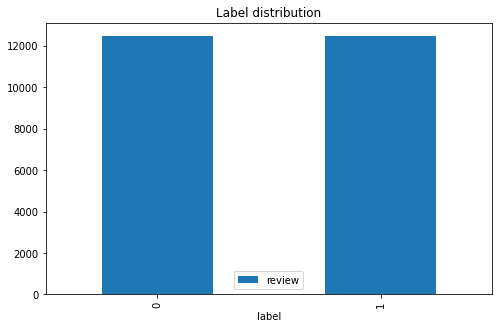

In [ ]:
# Import pyplot from matplotlib library
from matplotlib import pyplot as plt

# Plot a bar chart and display label distribution
ax = train_df.groupby("label").count().plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Label distribution")
plt.show()

### Data preparation

The text files contain HTML-tags which must be removed to improve the classification performance. The following code is based on [[3]](https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string).

In [ ]:
import re

cleanthml_re = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(cleanthml_re, '', raw_html)
  return cleantext

cleanbrackets_re = re.compile('\[[^]]*\]')
def cleanbrackets(raw_text):
  cleantext = re.sub(cleanbrackets_re,'', raw_text)
  return cleantext

cleanspecchar_re = re.compile(r'[^a-zA-z0-9\s]')
def cleanspecchar(raw_text):
  cleantext = re.sub(cleanspecchar_re, '', raw_text)
  return cleantext

In [ ]:
# Remove HTML tags in training data

train_df['review'] = train_df['review'].apply(cleanhtml)

In [ ]:
# Remove brackets in training data

train_df['review'] = train_df['review'].apply(cleanbrackets)

In [ ]:
# Remove special characters in training data

train_df['review'] = train_df['review'].apply(cleanspecchar)

### Create classification model

Now, we create our classification model. We use the ``bert_base_uncased`` model from the ``bert`` model family. The number of labels (categories) is set to 2 as we want to differ good and bad reviews.

**NOTE:** 
On all ``simpletransformers`` models, CUDA is enabled by default. Because of that, in order to proceed, you have to enable CUDA in your GPU. Please go to your notebook runtime type settings and choose "GPU". In colab GPU, CUDA is pre-installed. 

If you want, you can also disable CUDA.

Option-1: With CUDA (Recommended)

In [ ]:
# Create a classification model
## We will use 'bert' classification model
## We choose "uncased" (lowercase) bert model
## num_labels specifies he number of labels or classes in the dataset

model = ClassificationModel('bert', 'bert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Option-2: Without CUDA


In [ ]:
# Run this code to only disable CUDA:

#model = ClassificationModel('bert',
#                            'bert-base-uncased',
#                            num_labels=len(labels),
#                            use_cuda=False))

### Train model

We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters, and preprocesses our training data using a
subword tokenizer before the actual training process is started [[1]](#scrollTo=P4arl7P3xUuB).

In [ ]:
# Train the model
model.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/25000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/3125 [00:00<?, ?it/s]

(3125, 0.3829421696472168)

### Evaluation

We evaluate the model by using our evaluation set.

In [ ]:
# Evaluate the model
result, model_outputs, predictions = model.eval_model(test_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/25000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
print(result)

{'mcc': 0.7533237866000217, 'tp': 11170, 'tn': 10741, 'fp': 1759, 'fn': 1330, 'auroc': 0.9503647968000001, 'auprc': 0.9484853446447234, 'eval_loss': 0.3084963312149048}


# **References**

- [1] NLP and Computer Vision_DLMAINLPCV01 Course Book
- [2] https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda
- [3] https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string


Copyright © 2022 IU International University of Applied Sciences